# Предварителна обработка на данните (Data Preparation)

## Разпознаване на емоции - FER2013

В този notebook ще:

1. Заредим всички изображения в numpy масиви
2. Нормализираме пикселите (0-255 → 0-1)
3. Разделим train данните на train/validation
4. Изчислим class weights за дисбаланса
5. Запазим подготвените данни

**Забележка:** Запазваме данните в 2D формат `(48, 48)`. Reshape-ването ще се извърши в съответния model notebook:
- За SVM/Random Forest: `flatten` → `(2304,)`
- За CNN: `reshape` → `(48, 48, 1)`

## 1. Импортиране на библиотеки

In [3]:
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

## 2. Константи и настройки

In [4]:
# Пътища до данните
TRAIN_DIR = '../data/train'
TEST_DIR = '../data/test'

# Размер на изображенията
IMG_HEIGHT = 48
IMG_WIDTH = 48

# Емоции (класове)
EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
NUM_CLASSES = len(EMOTIONS)

# Процент за validation set
VALIDATION_SPLIT = 0.2

# Random seed за възпроизводимост
RANDOM_STATE = 42

print(f"Брой класове: {NUM_CLASSES}")
print(f"Емоции: {EMOTIONS}")
print(f"Размер на изображенията: {IMG_HEIGHT}x{IMG_WIDTH}")

Брой класове: 7
Емоции: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Размер на изображенията: 48x48


## 3. Зареждане на изображенията

Ще създадем функция, която:
1. Обхожда всички папки с емоции
2. Зарежда всяко изображение като numpy масив
3. Запазва съответния label (индекс на емоцията)

In [ ]:
def load_images(data_dir, emotions):
    """
    Зарежда всички изображения от директория.
    
    Args:
        data_dir: път до директорията (train или test)
        emotions: списък с имена на емоциите
    
    Returns:
        X: numpy масив с изображения (N, 48, 48)
        y: numpy масив с labels (N,)
    """
    images = []
    labels = []
    
    for label_idx, emotion in enumerate(emotions):
        emotion_dir = os.path.join(data_dir, emotion)
        
        if not os.path.exists(emotion_dir):
            print(f"Папката {emotion_dir} не съществува!")
            continue
        
        files = os.listdir(emotion_dir)
        print(f"Зареждане на {emotion}: {len(files)} изображения...")
        
        for filename in files:
            filepath = os.path.join(emotion_dir, filename)
            
            try:
                # Зареждаме изображението като grayscale
                img = Image.open(filepath).convert('L')
                img_array = np.array(img)
                
                # Проверяваме размера
                if img_array.shape == (IMG_HEIGHT, IMG_WIDTH):
                    images.append(img_array)
                    labels.append(label_idx)
                else:
                    print(f"Пропускаме {filename}: грешен размер {img_array.shape}")
                    
            except Exception as e:
                print(f"Грешка при {filename}: {e}")
    
    return np.array(images), np.array(labels)

In [6]:
# Зареждане на TRAIN данните
print("=" * 50)
print("ЗАРЕЖДАНЕ НА TRAIN ДАННИ")
print("=" * 50)
X_train_full, y_train_full = load_images(TRAIN_DIR, EMOTIONS)

print(f"\nЗаредени: {len(X_train_full)} изображения")
print(f"X shape: {X_train_full.shape}")
print(f"y shape: {y_train_full.shape}")

ЗАРЕЖДАНЕ НА TRAIN ДАННИ
Зареждане на angry: 3995 изображения...
Зареждане на disgust: 436 изображения...
Зареждане на fear: 4097 изображения...
Зареждане на happy: 7215 изображения...
Зареждане на neutral: 4965 изображения...
Зареждане на sad: 4830 изображения...
Зареждане на surprise: 3171 изображения...

Заредени: 28709 изображения
X shape: (28709, 48, 48)
y shape: (28709,)


In [7]:
# Зареждане на TEST данните
print("=" * 50)
print("ЗАРЕЖДАНЕ НА TEST ДАННИ")
print("=" * 50)
X_test, y_test = load_images(TEST_DIR, EMOTIONS)

print(f"\nЗаредени: {len(X_test)} изображения")
print(f"X shape: {X_test.shape}")
print(f"y shape: {y_test.shape}")

ЗАРЕЖДАНЕ НА TEST ДАННИ
Зареждане на angry: 958 изображения...
Зареждане на disgust: 111 изображения...
Зареждане на fear: 1024 изображения...
Зареждане на happy: 1774 изображения...
Зареждане на neutral: 1233 изображения...
Зареждане на sad: 1247 изображения...
Зареждане на surprise: 831 изображения...

Заредени: 7178 изображения
X shape: (7178, 48, 48)
y shape: (7178,)


## 4. Нормализация на пикселите

Нормализацията е важна и за класически алгоритми, и за невронни мрежи.

**Защо делим на 255?**
- Пикселите са цели числа от 0 до 255 (uint8)
- След деление получаваме стойности от 0.0 до 1.0 (float32)
- За SVM: помага за по-бърза конвергенция на оптимизацията(т.е. алгоритъмър изисква по-малко итерации за да се обучи)
- За невронни мрежи: помага за стабилно обучение

In [8]:
# Нормализация: [0, 255] -> [0, 1]
X_train_full = X_train_full.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print("След нормализация:")
print(f"X_train dtype: {X_train_full.dtype}")
print(f"X_train min: {X_train_full.min():.4f}")
print(f"X_train max: {X_train_full.max():.4f}")
print(f"\nФормат (запазен като 2D): {X_train_full.shape}")

След нормализация:
X_train dtype: float32
X_train min: 0.0000
X_train max: 1.0000

Формат (запазен като 2D): (28709, 48, 48)


## 5. Разделяне на Train/Validation

**Защо ни трябва validation set?**

- **Train set** - за обучение на модела
- **Validation set** - за проверка по време на обучение (hyperparameter tuning)
- **Test set** - само за финална оценка (не го пипаме до края!)

Използваме `stratify=y` за да запазим пропорциите на класовете.

In [9]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, 
    y_train_full,
    test_size=VALIDATION_SPLIT,
    random_state=RANDOM_STATE,
    stratify=y_train_full  # Запазва пропорциите на класовете
)

print(f"Train set: {X_train.shape[0]} изображения")
print(f"Validation set: {X_val.shape[0]} изображения")
print(f"Test set: {X_test.shape[0]} изображения")
print(f"\nФормат на данните: {X_train.shape}")

Train set: 22967 изображения
Validation set: 5742 изображения
Test set: 7178 изображения

Формат на данните: (22967, 48, 48)


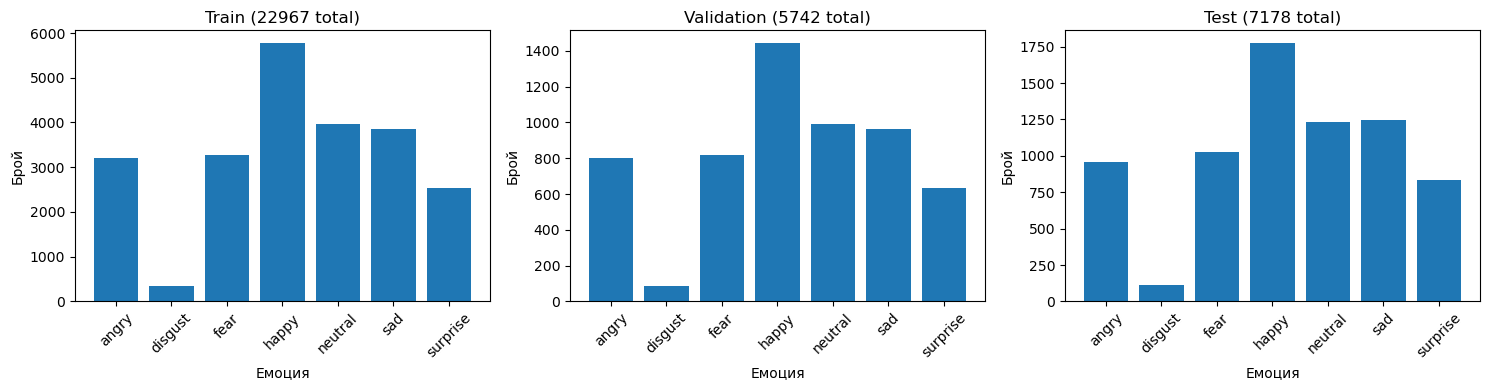

In [10]:
# Проверка на разпределението след split
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (data, title) in zip(axes, [(y_train, 'Train'), (y_val, 'Validation'), (y_test, 'Test')]):
    counts = [np.sum(data == i) for i in range(NUM_CLASSES)]
    ax.bar(EMOTIONS, counts)
    ax.set_title(f'{title} ({len(data)} total)')
    ax.set_xlabel('Емоция')
    ax.set_ylabel('Брой')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 6. Изчисляване на Class Weights

Поради силния дисбаланс в данните (16.5x разлика между най-големия и най-малкия клас), трябва да използваме **class weights**.

**Как работи?**
- Малките класове (като "disgust") получават по-голяма тежест
- Големите класове (като "happy") получават по-малка тежест
- Така моделът се "наказва" повече, когато сбърка малък клас

**Използване:**
- В SVM: параметър `class_weight='balanced'` или custom weights
- В Keras: параметър `class_weight` в `model.fit()`

In [11]:
# Изчисляване на class weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Преобразуване в речник (формат за Keras и sklearn)
class_weights = {i: weight for i, weight in enumerate(class_weights_array)}

print("Class Weights:")
print("-" * 30)
for i, emotion in enumerate(EMOTIONS):
    print(f"{emotion:10s}: {class_weights[i]:.4f}")

Class Weights:
------------------------------
angry     : 1.0266
disgust   : 9.4011
fear      : 1.0012
happy     : 0.5684
neutral   : 0.8260
sad       : 0.8491
surprise  : 1.2933


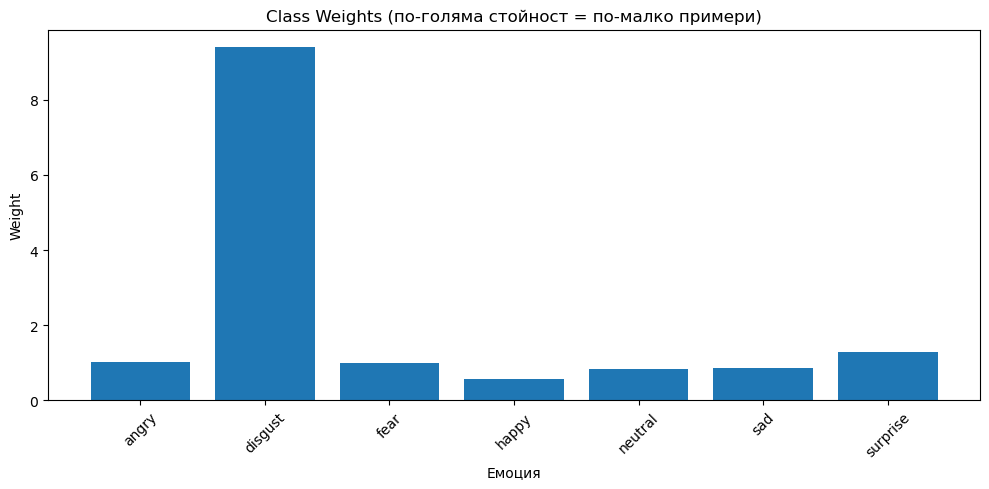

In [12]:
# Визуализация на class weights
plt.figure(figsize=(10, 5))
plt.bar(EMOTIONS, class_weights_array)
plt.title('Class Weights (по-голяма стойност = по-малко примери)')
plt.xlabel('Емоция')
plt.ylabel('Weight')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 7. Запазване на данните

Запазваме подготвените данни в `.npz` формат за лесно зареждане в следващите notebooks.

**Важно:** Данните са в 2D формат `(N, 48, 48)`. Reshape-ването ще се извърши в model notebooks.

In [13]:
# Създаваме папка за processed данни
PROCESSED_DIR = '../data/processed'
os.makedirs(PROCESSED_DIR, exist_ok=True)

# Запазваме всички данни
np.savez_compressed(
    os.path.join(PROCESSED_DIR, 'fer2013_processed.npz'),
    X_train=X_train,
    X_val=X_val,
    X_test=X_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    class_weights=class_weights_array,
    emotions=np.array(EMOTIONS)
)

print(f"Данните са запазени в: {PROCESSED_DIR}/fer2013_processed.npz")

Данните са запазени в: ../data/processed/fer2013_processed.npz


In [14]:
# Проверка на файла
file_path = os.path.join(PROCESSED_DIR, 'fer2013_processed.npz')
file_size = os.path.getsize(file_path) / (1024 * 1024)  # MB

print(f"Размер на файла: {file_size:.2f} MB")

Размер на файла: 101.85 MB


## 8. Проверка - Зареждане на данните

Тестваме дали можем да заредим данните правилно.

In [15]:
# Тест: Зареждане на данните
data = np.load(os.path.join(PROCESSED_DIR, 'fer2013_processed.npz'), allow_pickle=True)

print("Заредени масиви:")
for key in data.files:
    arr = data[key]
    if hasattr(arr, 'shape'):
        print(f"  {key}: {arr.shape} ({arr.dtype})")
    else:
        print(f"  {key}: {arr}")

Заредени масиви:
  X_train: (22967, 48, 48) (float32)
  X_val: (5742, 48, 48) (float32)
  X_test: (7178, 48, 48) (float32)
  y_train: (22967,) (int64)
  y_val: (5742,) (int64)
  y_test: (7178,) (int64)
  class_weights: (7,) (float64)
  emotions: (7,) (<U8)


## 9. Визуална проверка

Проверяваме дали нормализираните изображения изглеждат правилно.

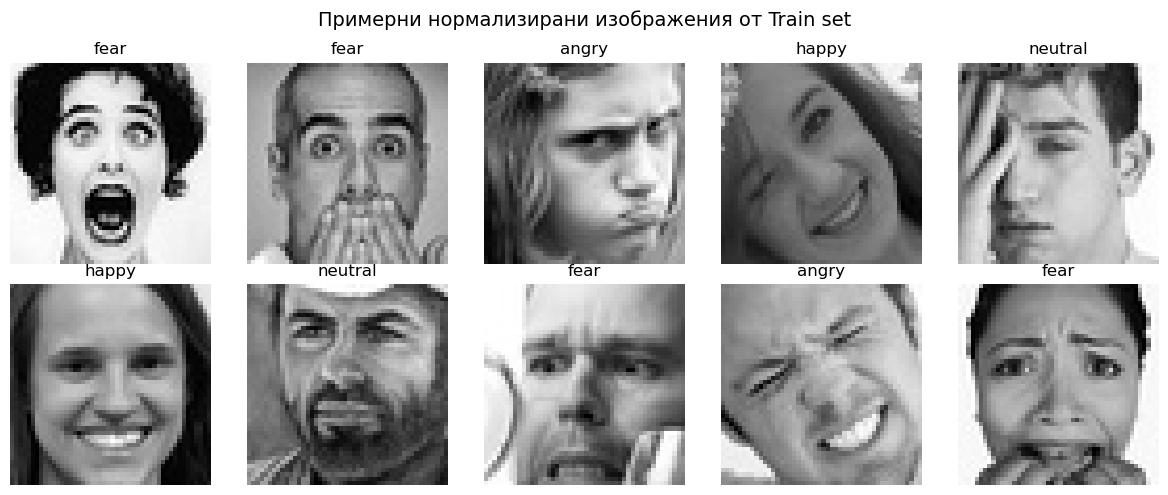

In [16]:
# Показваме няколко примера от train set
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for i, ax in enumerate(axes.flat):
    img = X_train[i]  # Вече е 2D (48, 48)
    label = y_train[i]
    
    ax.imshow(img, cmap='gray')
    ax.set_title(f"{EMOTIONS[label]}")
    ax.axis('off')

plt.suptitle('Примерни нормализирани изображения от Train set', fontsize=14)
plt.tight_layout()
plt.show()

## 10. Демонстрация: Reshape за различни модели

Показваме как да преобразуваме данните за различни типове модели.

In [17]:
# За SVM / Random Forest: Flatten към 1D вектор
X_train_flat = X_train.reshape(X_train.shape[0], -1)
print(f"За SVM/RF (flatten):")
print(f"  X_train: {X_train.shape} -> {X_train_flat.shape}")
print(f"  Всяко изображение е вектор с {X_train_flat.shape[1]} features (48*48)")

print()

# За CNN: Добавяне на channel dimension
X_train_cnn = X_train.reshape(X_train.shape[0], IMG_HEIGHT, IMG_WIDTH, 1)
print(f"За CNN (add channel):")
print(f"  X_train: {X_train.shape} -> {X_train_cnn.shape}")
print(f"  Формат: (batch, height, width, channels)")

За SVM/RF (flatten):
  X_train: (22967, 48, 48) -> (22967, 2304)
  Всяко изображение е вектор с 2304 features (48*48)

За CNN (add channel):
  X_train: (22967, 48, 48) -> (22967, 48, 48, 1)
  Формат: (batch, height, width, channels)


## 11. Обобщение

### Какво направихме?

| Стъпка | Описание |
|--------|----------|
| Зареждане | Заредихме 28,709 train и 7,178 test изображения |
| Нормализация | Преобразувахме пикселите от [0-255] към [0-1] |
| Train/Val split | Разделихме train на 80% train / 20% validation |
| Class weights | Изчислихме тегла за балансиране на класовете |
| Запазване | Запазихме всичко в `fer2013_processed.npz` |

### Финални размери на данните

```
X_train:  (22967, 48, 48) - за обучение
X_val:    (5742, 48, 48)  - за валидация
X_test:   (7178, 48, 48)  - за финална оценка
```

### Използване в следващите notebooks

```python
# Зареждане на данните
data = np.load('../data/processed/fer2013_processed.npz', allow_pickle=True)
X_train = data['X_train']
y_train = data['y_train']
# ...

# За SVM/Random Forest:
X_train_flat = X_train.reshape(X_train.shape[0], -1)

# За CNN:
X_train_cnn = X_train.reshape(-1, 48, 48, 1)
```

### Следваща стъпка

В следващия notebook (`03_baseline_model.ipynb`) ще:
1. Заредим подготвените данни
2. Flatten-ем изображенията за класически ML
3. Обучим SVM или Random Forest като baseline
4. Оценим резултатите с confusion matrix и F1-score